## Read tick-by-tick data
Source: TrueFX
URL: https://www.truefx.com/

In [312]:
# Columns naming and concatenate
import pandas as pd
cols = ["pair", "dt_str", "bid", "ask"]

september = pd.read_csv("data/EURPLN09.csv",
                        header=None, names=cols)

october = pd.read_csv("data/EURPLN10.csv",
                      header=None, names=cols)

# Convert the date-time string column to pandas Timestamp
for df in (september, october):
    df["timestamp"] = pd.to_datetime(df["dt_str"])
    df["bid"] = pd.to_numeric(df["bid"], errors="coerce")
    df["ask"] = pd.to_numeric(df["ask"], errors="coerce")

In [313]:
# Let's drop the raw string column and the pair column
september = september.drop(columns=["pair","dt_str"])
october   = october.drop(columns=["pair","dt_str"])

In [314]:
# LEt's exclude the rest of October
start_oct = pd.Timestamp("2025-10-01 00:00:00")
end_oct   = pd.Timestamp("2025-10-06 00:00:00") 

october_filtered = october[
    (october["timestamp"] >= start_oct) &
    (october["timestamp"] <  end_oct)
]

In [315]:
# Let's concatenate the two datasets.
full = pd.concat(
    [september, october_filtered],
    axis=0,
    ignore_index=True
)

# LEt's ensure sorted by time
full = full.sort_values("timestamp").reset_index(drop=True)

In [316]:
full.head()

,bid,ask,timestamp
0,4.26085,4.26341,2025-09-01 00:00:00.014
1,4.26097,4.26341,2025-09-01 00:00:00.052
2,4.26114,4.26341,2025-09-01 00:00:00.052
3,4.26010,4.26328,2025-09-01 00:00:00.400
4,4.26125,4.26341,2025-09-01 00:00:00.469


In [317]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171015 entries, 0 to 3171014
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   bid        float64       
 1   ask        float64       
 2   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 72.6 MB


## Data aggregation and adding some new fetures

In [318]:
import numpy as np

full = full.sort_values("timestamp").set_index("timestamp")

# Basic microstructure columns
full["mid"]    = (full["bid"] + full["ask"]) / 2
full["spread"] = full["ask"] - full["bid"]

In [319]:
# No NA at this stage
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3171015 entries, 2025-09-01 00:00:00.014000 to 2025-10-05 23:59:53.074000
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   bid     float64
 1   ask     float64
 2   mid     float64
 3   spread  float64
dtypes: float64(4)
memory usage: 121.0 MB


In [320]:
# Time Aggregation to 1 minutes
minute = (
    full
    .resample("1T")
    .agg(
        # Bid OHLC
        bid_open  = ("bid", "first"),
        bid_high  = ("bid", "max"),
        bid_low   = ("bid", "min"),
        bid_close = ("bid", "last"),

        # Ask OHLC
        ask_open  = ("ask", "first"),
        ask_high  = ("ask", "max"),
        ask_low   = ("ask", "min"),
        ask_close = ("ask", "last"),

        # Average bid/ask over the minute
        bid_avg = ("bid", "mean"),  
        ask_avg = ("ask", "mean"),

        # Spread: only average, no min/max
        spread_avg = ("spread", "mean"),

        # Activity
        tick_count = ("mid", "size"),

    )
)

# Midprice as average of mean bid and mean ask - very important feature in this project
minute["mid_avg"] = (minute["bid_avg"] + minute["ask_avg"]) / 2


C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\2605080246.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("1T")


In [321]:
minute.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,bid_avg,ask_avg,spread_avg,tick_count,mid_avg
timestamp,,,,,,,,,,,,,
2025-09-01 00:00:00,4.26085,4.26140,4.2598,4.26121,4.26341,4.26341,4.26257,4.26257,4.260784,4.262837,0.002052,138,4.261810
2025-09-01 00:01:00,4.26050,4.26121,4.2605,4.26121,4.26278,4.26278,4.26257,4.26257,4.260889,4.262675,0.001786,44,4.261782
2025-09-01 00:02:00,4.26060,4.26121,4.2606,4.26060,4.26278,4.26278,4.26257,4.26278,4.260895,4.262678,0.001783,31,4.261787
2025-09-01 00:03:00,4.26121,4.26125,4.2606,4.26118,4.26257,4.26278,4.26252,4.26256,4.260965,4.262653,0.001688,28,4.261809
2025-09-01 00:04:00,4.26060,4.26121,4.2606,4.26118,4.26278,4.26278,4.26252,4.26256,4.260951,4.262657,0.001706,20,4.261804


In [322]:
# 15 103 rows are missing
minute.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50400 entries, 2025-09-01 00:00:00 to 2025-10-05 23:59:00
Freq: min
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bid_open    35297 non-null  float64
 1   bid_high    35297 non-null  float64
 2   bid_low     35297 non-null  float64
 3   bid_close   35297 non-null  float64
 4   ask_open    35297 non-null  float64
 5   ask_high    35297 non-null  float64
 6   ask_low     35297 non-null  float64
 7   ask_close   35297 non-null  float64
 8   bid_avg     35297 non-null  float64
 9   ask_avg     35297 non-null  float64
 10  spread_avg  35297 non-null  float64
 11  tick_count  50400 non-null  int64  
 12  mid_avg     35297 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 5.4 MB


## Missing values inspection (Weekends)

In [323]:
nas = minute[minute['bid_open'].isna()]
nas.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,bid_avg,ask_avg,spread_avg,tick_count,mid_avg
timestamp,,,,,,,,,,,,,
2025-09-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-09-01 21:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-09-01 21:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-09-02 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-09-02 21:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [324]:
nas.groupby(nas.index.hour).size().sort_values(ascending = False)

timestamp
21    812
20    688
23    656
2     646
0     639
19    636
22    634
5     629
18    628
4     627
3     626
1     619
9     616
15    612
11    607
8     606
10    606
12    605
13    604
6     602
17    602
14    602
16    601
7     600
dtype: int64

In [325]:
nas.groupby(nas.index.date).size().sort_values(ascending = False)

2025-09-27    1440
2025-09-13    1440
2025-09-06    1440
2025-10-04    1440
2025-09-20    1440
2025-10-05    1320
2025-09-14    1316
2025-09-28    1264
2025-09-21    1264
2025-09-07    1261
2025-09-12     202
2025-09-19     182
2025-10-03     182
2025-09-05     181
2025-09-26     180
2025-09-23     174
2025-09-15     170
2025-09-22     136
2025-09-17       7
2025-09-08       6
2025-09-10       6
2025-09-03       6
2025-09-29       6
2025-09-09       5
2025-09-11       5
2025-09-30       4
2025-09-25       4
2025-09-02       3
2025-09-01       3
2025-09-16       3
2025-09-18       3
2025-10-01       3
2025-09-24       3
2025-09-04       2
2025-10-02       2
dtype: int64

Forex trading closes on Friday 5 PM and reopens on Sunday 5 PM. Let's remove these dates from our dataset

In [326]:
# Made with AI help
# Extract local time components
times = minute.index

# Condition 1: Keep all rows before Friday 17:00
cond_weekday = ~(
    (times.weekday == 4) &                 # Friday
    (times.hour >= 17)                     # 5pm+
)

# Condition 2: Keep all rows after Sunday 17:00
cond_weekend = ~(
    (times.weekday == 6) &                 # Sunday
    (times.hour < 17)                      # before 5pm
)

# Remove Saturday and Sunday (before 17:00)
cond_fullweekend = ~(
    (times.weekday == 5) |                 # Saturday
    ( (times.weekday == 6) & (times.hour < 17) )  # Sunday before 5pm
)

# Combine all conditions
valid = cond_weekday & cond_fullweekend

filtered = minute[valid]

In [327]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36000 entries, 2025-09-01 00:00:00 to 2025-10-05 23:59:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bid_open    34117 non-null  float64
 1   bid_high    34117 non-null  float64
 2   bid_low     34117 non-null  float64
 3   bid_close   34117 non-null  float64
 4   ask_open    34117 non-null  float64
 5   ask_high    34117 non-null  float64
 6   ask_low     34117 non-null  float64
 7   ask_close   34117 non-null  float64
 8   bid_avg     34117 non-null  float64
 9   ask_avg     34117 non-null  float64
 10  spread_avg  34117 non-null  float64
 11  tick_count  36000 non-null  int64  
 12  mid_avg     34117 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 3.8 MB


In [328]:
# Let's jsut drop the minority of missing value that left
minute = filtered.dropna()
minute.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,bid_avg,ask_avg,spread_avg,tick_count,mid_avg
timestamp,,,,,,,,,,,,,
2025-09-01 00:00:00,4.26085,4.26140,4.2598,4.26121,4.26341,4.26341,4.26257,4.26257,4.260784,4.262837,0.002052,138,4.261810
2025-09-01 00:01:00,4.26050,4.26121,4.2605,4.26121,4.26278,4.26278,4.26257,4.26257,4.260889,4.262675,0.001786,44,4.261782
2025-09-01 00:02:00,4.26060,4.26121,4.2606,4.26060,4.26278,4.26278,4.26257,4.26278,4.260895,4.262678,0.001783,31,4.261787
2025-09-01 00:03:00,4.26121,4.26125,4.2606,4.26118,4.26257,4.26278,4.26252,4.26256,4.260965,4.262653,0.001688,28,4.261809
2025-09-01 00:04:00,4.26060,4.26121,4.2606,4.26118,4.26278,4.26278,4.26252,4.26256,4.260951,4.262657,0.001706,20,4.261804


In [329]:
# No NAs at this stage 
minute.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34117 entries, 2025-09-01 00:00:00 to 2025-10-05 23:59:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bid_open    34117 non-null  float64
 1   bid_high    34117 non-null  float64
 2   bid_low     34117 non-null  float64
 3   bid_close   34117 non-null  float64
 4   ask_open    34117 non-null  float64
 5   ask_high    34117 non-null  float64
 6   ask_low     34117 non-null  float64
 7   ask_close   34117 non-null  float64
 8   bid_avg     34117 non-null  float64
 9   ask_avg     34117 non-null  float64
 10  spread_avg  34117 non-null  float64
 11  tick_count  34117 non-null  int64  
 12  mid_avg     34117 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 3.6 MB


## Creation of the most important feature - log returns of average mid price

In [330]:
minute["log_mid_returns"] = np.log(minute["mid_avg"] / minute["mid_avg"].shift(1))

C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\408647633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minute["log_mid_returns"] = np.log(minute["mid_avg"] / minute["mid_avg"].shift(1))


In [331]:
minute.head(10)

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,bid_avg,ask_avg,spread_avg,tick_count,mid_avg,log_mid_returns
timestamp,,,,,,,,,,,,,,
2025-09-01 00:00:00,4.26085,4.26140,4.2598,4.26121,4.26341,4.26341,4.26257,4.26257,4.260784,4.262837,0.002052,138,4.261810,NaN
2025-09-01 00:01:00,4.26050,4.26121,4.2605,4.26121,4.26278,4.26278,4.26257,4.26257,4.260889,4.262675,0.001786,44,4.261782,-6.644350e-06
2025-09-01 00:02:00,4.26060,4.26121,4.2606,4.26060,4.26278,4.26278,4.26257,4.26278,4.260895,4.262678,0.001783,31,4.261787,1.109568e-06
2025-09-01 00:03:00,4.26121,4.26125,4.2606,4.26118,4.26257,4.26278,4.26252,4.26256,4.260965,4.262653,0.001688,28,4.261809,5.282165e-06
2025-09-01 00:04:00,4.26060,4.26121,4.2606,4.26118,4.26278,4.26278,4.26252,4.26256,4.260951,4.262657,0.001706,20,4.261804,-1.240252e-06
2025-09-01 00:05:00,4.26060,4.26119,4.2606,4.26118,4.26278,4.26278,4.26256,4.26256,4.260918,4.262660,0.001742,22,4.261789,-3.498311e-06
2025-09-01 00:06:00,4.26060,4.26118,4.2606,4.26104,4.26278,4.26278,4.26256,4.26256,4.260883,4.262664,0.001781,19,4.261774,-3.615084e-06
2025-09-01 00:07:00,4.26060,4.26123,4.2606,4.26123,4.26278,4.26278,4.26256,4.26256,4.260937,4.262646,0.001709,23,4.261792,4.236471e-06
2025-09-01 00:08:00,4.26060,4.26123,4.2606,4.26060,4.26278,4.26278,4.26256,4.26278,4.260910,4.262659,0.001748,20,4.261785,-1.639953e-06


In [332]:
minute = minute.dropna()

## Train-Test Split

In [333]:
# Let's exclude the rest of October
date = pd.Timestamp("2025-09-22 00:00:00")

train = minute[minute.index < date]
test = minute[minute.index >= date]

In [334]:
test.to_csv('data/testset.csv')

## EDA

In [335]:
train.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,bid_avg,ask_avg,spread_avg,tick_count,mid_avg,log_mid_returns
timestamp,,,,,,,,,,,,,,
2025-09-01 00:01:00,4.26050,4.26121,4.2605,4.26121,4.26278,4.26278,4.26257,4.26257,4.260889,4.262675,0.001786,44,4.261782,-0.000007
2025-09-01 00:02:00,4.26060,4.26121,4.2606,4.26060,4.26278,4.26278,4.26257,4.26278,4.260895,4.262678,0.001783,31,4.261787,0.000001
2025-09-01 00:03:00,4.26121,4.26125,4.2606,4.26118,4.26257,4.26278,4.26252,4.26256,4.260965,4.262653,0.001688,28,4.261809,0.000005
2025-09-01 00:04:00,4.26060,4.26121,4.2606,4.26118,4.26278,4.26278,4.26252,4.26256,4.260951,4.262657,0.001706,20,4.261804,-0.000001
2025-09-01 00:05:00,4.26060,4.26119,4.2606,4.26118,4.26278,4.26278,4.26256,4.26256,4.260918,4.262660,0.001742,22,4.261789,-0.000003


<Axes: xlabel='timestamp'>

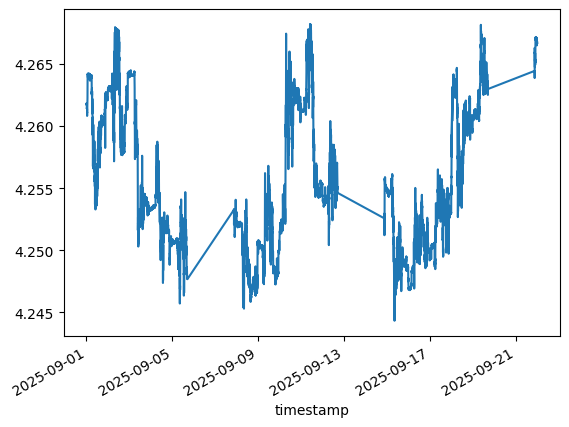

In [336]:
import plotly
train['mid_avg'].plot()

<Axes: xlabel='timestamp'>

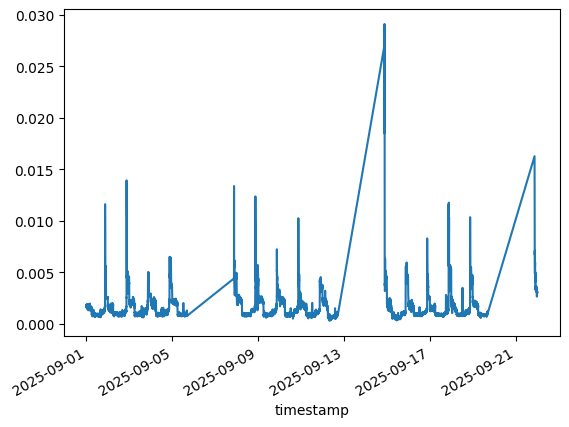

In [337]:
train['spread_avg'].plot()

<Axes: xlabel='timestamp'>

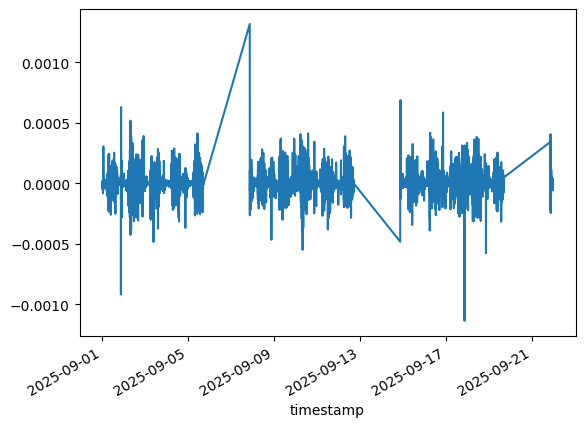

In [338]:
train['log_mid_returns'].plot()

It is hard to distinguish any particular pattern on the graphs

## Feature engineering and adding more features

In [340]:
# Friday and Sunday are the days of limited trading activity. Let's add a dummy variable indicating one of these days
train['is_friday'] = (train.index.dayofweek == 4).astype(int)
train['is_sunday'] = (train.index.dayofweek == 6).astype(int)

C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\4240859820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_friday'] = (train.index.dayofweek == 4).astype(int)
C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\4240859820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_sunday'] = (train.index.dayofweek == 6).astype(int)


## Lagged values

It was important to perform the train/test splitting before creating more features ex. lagged variables. In other case, we would leak some data to the out-of-sample subset 

In [341]:
train.columns

Index(['bid_open', 'bid_high', 'bid_low', 'bid_close', 'ask_open', 'ask_high',
       'ask_low', 'ask_close', 'bid_avg', 'ask_avg', 'spread_avg',
       'tick_count', 'mid_avg', 'log_mid_returns', 'is_friday', 'is_sunday'],
      dtype='object')

In [342]:
# Wazne, aby najpierw przetransformowac raw prices features na log returns...
prices_to_log = ['bid_open', 'bid_high', 'bid_low', 'bid_close', 'ask_open', 'ask_high',
       'ask_low', 'ask_close', 'bid_avg', 'ask_avg']
for feature in prices_to_log:
    train[f'log{feature}_returns'] = np.log(train[feature] / train[feature].shift(1))

# ...i pozbyc sie raw prices
train = train.drop(columns=['bid_open', 'bid_high', 'bid_low', 'bid_close', 'ask_open', 'ask_high',
       'ask_low', 'ask_close', 'bid_avg', 'ask_avg'])

train.columns

C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\4086913749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'log{feature}_returns'] = np.log(train[feature] / train[feature].shift(1))
C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\4086913749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'log{feature}_returns'] = np.log(train[feature] / train[feature].shift(1))
C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\4086913749.py:5: SettingWithCopyWarning: 
A value is trying to be set on

Index(['spread_avg', 'tick_count', 'mid_avg', 'log_mid_returns', 'is_friday',
       'is_sunday', 'logbid_open_returns', 'logbid_high_returns',
       'logbid_low_returns', 'logbid_close_returns', 'logask_open_returns',
       'logask_high_returns', 'logask_low_returns', 'logask_close_returns',
       'logbid_avg_returns', 'logask_avg_returns'],
      dtype='object')

In [343]:
# we already have log_mid_returns, so let's drop mid_avg
train = train.drop(columns=['mid_avg'])

In [344]:
# W sumie lagujemy wszustkie features poza dniem - intersuje nas tylko czy dzis jest 
# piatek badz niedziela, a nie co bylo wczoraj badz przedwczoraj
features_to_lag = ['spread_avg', 'tick_count', 'log_mid_returns',
       'logbid_open_returns', 'logbid_high_returns', 'logbid_low_returns',
       'logbid_close_returns', 'logask_open_returns', 'logask_high_returns',
       'logask_low_returns', 'logask_close_returns', 'logbid_avg_returns',
       'logask_avg_returns']

# How many minutes back? - but actually it is a parameter to be optimized. Previously I did [1,2,3,5,10], but I received better results with this set of lags
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create lagged features
for feat in features_to_lag:
    for k in lags:
        train[f'{feat}_lag_{k}'] = train[feat].shift(k)

C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\3180716885.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feat}_lag_{k}'] = train[feat].shift(k)
C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\3180716885.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feat}_lag_{k}'] = train[feat].shift(k)
C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\3180716885.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [345]:
# To zapewne stworzylo kilka NA
train.head(11)
# owszem. Usunmy je
train = train.dropna()

## Defining the Target variable 

In [348]:
# 1. Column with the log returns 3 minutes later
#    So the value for the first minute, will be the log return for the 4th minute and so on...
#    ATTENTION! Pracujemy na mid prices, a przeciez kupujemy za ASK, sprzedajemy po BID. Jest to slaba strona mojego projektu...
train['log_mid_return_3+'] = train['log_mid_returns'].shift(-3)

# 2. Define the threshold. let's take the absolute values of our log returns,
#    and compute the median. The predicted log return 3 periods later being higher than half
#    of the median will mean that we shouldnt stay flat
thr = train['log_mid_returns'].abs().median() * 0.5
# zrobienie tego samego z test set stworzyloby data leakage. Trzeba wiec zapisac ta liczbe
# i potem po prostu ja zaimportujemy
import json
with open("threshold.json", "w") as f:
    json.dump({"thr": float(thr)}, f)

# 3. Compute classification target
# - jesli predicted log return is bigger than threshold (+ values), lets go long
# - jesli predicted log return (bedacy zapwne minusowy) jest mniejszy niz liczba przeciwna 
#   do threshold, we go short
# - Otherwise, stay flat
# REMARK! I decided to penalize more the losses - that's why you can see -0.8 * thr
y = np.where(train['log_mid_return_3+'] > thr, 1,
    np.where(train['log_mid_return_3+'] < -0.8 * thr, -1, 0))

y = pd.Series(y, index=train.index, name='target')


# 4. - Prawie to mamy. Warto jeszcze jednak zauwazyc, ze ostatnie 5 minut przed zamknieciem gieldy (16:55-17:00) odpuscimy sobie tradowanie.
# - Warto tez zauwazyc, ze pierwsze 10 min w niedziele nie beda posiadac lagow. Ale mozemy
# to w sumie usunac prostym .droopna(), takze narazie sie tym nie przejmujemy
from datetime import time
idx = train.index

friday_last5 = (
    (idx.weekday == 4) &
    (idx.time >= time(16, 55)) &
    (idx.time <  time(17, 0))
)
y.loc[friday_last5] = 0

print(y)

timestamp
2025-09-01 00:12:00    0
2025-09-01 00:13:00    0
2025-09-01 00:14:00    1
2025-09-01 00:15:00    0
2025-09-01 00:16:00   -1
                      ..
2025-09-21 23:55:00    1
2025-09-21 23:56:00   -1
2025-09-21 23:57:00    0
2025-09-21 23:58:00    0
2025-09-21 23:59:00    0
Name: target, Length: 20581, dtype: int64


C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\125227584.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['log_mid_return_3+'] = train['log_mid_returns'].shift(-3)


In [349]:
train['target'] = y
train.head()

C:\Users\grzes\AppData\Local\Temp\ipykernel_24304\3098357125.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['target'] = y


,spread_avg,tick_count,log_mid_returns,is_friday,is_sunday,logbid_open_returns,logbid_high_returns,logbid_low_returns,logbid_close_returns,logask_open_returns,...,logask_avg_returns_lag_3,logask_avg_returns_lag_4,logask_avg_returns_lag_5,logask_avg_returns_lag_6,logask_avg_returns_lag_7,logask_avg_returns_lag_8,logask_avg_returns_lag_9,logask_avg_returns_lag_10,log_mid_return_3+,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-01 00:12:00,0.001781,13,9.927282e-07,0,0,0.000000,0.000000,0.000000,0.000019,0.000000,...,5.955111e-07,3.029345e-06,-4.251709e-06,9.877692e-07,7.037861e-07,8.881118e-07,-5.905415e-06,7.945939e-07,-0.000003,0
2025-09-01 00:13:00,0.001833,22,-4.344219e-06,0,0,-0.000162,0.000000,-0.000023,0.000000,0.000047,...,5.079553e-07,5.955111e-07,3.029345e-06,-4.251709e-06,9.877692e-07,7.037861e-07,8.881118e-07,-5.905415e-06,-0.000002,0
2025-09-01 00:14:00,0.001817,16,-1.093237e-06,0,0,-0.000023,0.000031,0.000000,-0.000028,0.000000,...,-6.282623e-06,5.079553e-07,5.955111e-07,3.029345e-06,-4.251709e-06,9.877692e-07,7.037861e-07,8.881118e-07,0.000009,1
2025-09-01 00:15:00,0.001870,26,-3.226388e-06,0,0,0.000000,-0.000033,0.000000,0.000026,0.000000,...,3.609171e-06,-6.282623e-06,5.079553e-07,5.955111e-07,3.029345e-06,-4.251709e-06,9.877692e-07,7.037861e-07,0.000004,0
2025-09-01 00:16:00,0.001886,14,-1.927457e-06,0,0,0.000162,-0.000021,0.000000,-0.000021,-0.000047,...,1.804581e-06,3.609171e-06,-6.282623e-06,5.079553e-07,5.955111e-07,3.029345e-06,-4.251709e-06,9.877692e-07,-0.000005,-1


In [350]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20581 entries, 2025-09-01 00:12:00 to 2025-09-21 23:59:00
Columns: 147 entries, spread_avg to target
dtypes: float64(143), int64(4)
memory usage: 23.2 MB


In [351]:
train[train.isna().any(axis=1)]

,spread_avg,tick_count,log_mid_returns,is_friday,is_sunday,logbid_open_returns,logbid_high_returns,logbid_low_returns,logbid_close_returns,logask_open_returns,...,logask_avg_returns_lag_3,logask_avg_returns_lag_4,logask_avg_returns_lag_5,logask_avg_returns_lag_6,logask_avg_returns_lag_7,logask_avg_returns_lag_8,logask_avg_returns_lag_9,logask_avg_returns_lag_10,log_mid_return_3+,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-21 23:57:00,0.002989,32,-0.000013,0,1,0.000000,-0.000005,-0.000016,-0.000030,0.000000,...,-0.000006,0.000003,-0.000011,4.847249e-07,-1.906567e-05,-5.622687e-06,-4.409937e-07,1.920378e-05,NaN,0
2025-09-21 23:58:00,0.003152,22,0.000013,0,1,-0.000009,-0.000009,0.000000,0.000009,0.000105,...,0.000025,-0.000006,0.000003,-1.070440e-05,4.847249e-07,-1.906567e-05,-5.622687e-06,-4.409937e-07,NaN,0
2025-09-21 23:59:00,0.003003,23,-0.000010,0,1,0.000000,0.000000,0.000009,0.000007,0.000000,...,-0.000036,0.000025,-0.000006,2.764573e-06,-1.070440e-05,4.847249e-07,-1.906567e-05,-5.622687e-06,NaN,0


In [352]:
# Of course - we do not have target values for the last 3 minutes of the train set (we try te predict what happens 3 minutes later). 
# LEt's drop the NAs again
train = train.dropna()

In [353]:
train.isna().any().any()

np.False_

In [354]:
train['target'].value_counts()

target
-1    7375
 1    6698
 0    6505
Name: count, dtype: int64

In [355]:
# log_mid_return_3+ is of course forward-looking. Let's drop it
train = train.drop(columns=['log_mid_return_3+'])

## Algo training - LightGBM

In [356]:
# Imports
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [357]:
# Step 1 – Define features X and labels y from algo_train

# 1) List of feature columns (everything except 'target')
feature_cols = [col for col in train.columns if col != 'target']

# 2) Feature matrix
X_train_full = train[feature_cols]

# 3) Label vector
y_train_full = train['target']

In [358]:
# Step 2 – Time-based split inside algo_train (train vs validation)
n_samples = len(train)
# index where validation starts
split_idx = int(n_samples * 0.8)   

# Training part (earlier in time)
X_tr = X_train_full.iloc[:split_idx]
y_tr = y_train_full.iloc[:split_idx]

# Validation part (later in time)
X_val = X_train_full.iloc[split_idx:]
y_val = y_train_full.iloc[split_idx:]


In [359]:
# Step 3 – Instantiate the LightGBM classifier
# Made with AI help
lgbm_clf = LGBMClassifier(
    objective='multiclass',
    num_class=3,          # because target is -1, 0, +1 (3 classes)
    n_estimators=500,     # max number of trees (we'll use early stopping)
    learning_rate=0.05,   # smaller lr → more stable, slower learning
    max_depth=-1,         # -1 = no limit, let the model choose
    subsample=0.8,        # row subsampling (for each tree)
    colsample_bytree=0.8, # feature subsampling (for each tree)
    random_state=42,      # reproducible results
    n_jobs=-1             # use all CPU cores
)


In [360]:
# Step 4 – Fit the model with early stopping
from lightgbm import early_stopping, log_evaluation

lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36469
[LightGBM] [Info] Number of data points in the train set: 16462, number of used features: 145
[LightGBM] [Info] Start training from score -1.026102
[LightGBM] [Info] Start training from score -1.125080
[LightGBM] [Info] Start training from score -1.148941
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.00066
[100]	valid_0's multi_logloss: 0.998887
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.998743


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               n_jobs=-1, num_class=3, objective='multiclass', random_state=42,
               subsample=0.8)

In [361]:
# Step 5 – Evaluate on the validation slice
# 1) Get predictions (class labels -1/0/+1)
y_val_pred = lgbm_clf.predict(X_val)

# 2) Accuracy
val_acc = accuracy_score(y_val, y_val_pred)

# 3) Macro F1 (treat all 3 classes equally)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print("Validation accuracy:", val_acc)
print("Validation macro F1:", val_f1)

# 4) More detailed report
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))


Validation accuracy: 0.4589407191448008
Validation macro F1: 0.45332628792989976
              precision    recall  f1-score   support

          -1       0.42      0.52      0.46      1475
           0       0.52      0.65      0.58      1161
           1       0.44      0.25      0.32      1480

    accuracy                           0.46      4116
   macro avg       0.46      0.47      0.45      4116
weighted avg       0.46      0.46      0.44      4116

[[766 365 344]
 [282 755 124]
 [786 326 368]]


## LightGBM on test set

In [362]:
algo_test = pd.read_csv("algo_test_processed.csv", index_col="timestamp")
algo_test = algo_test.dropna()

X_test = algo_test[feature_cols]   
y_test = algo_test['target']

# # Hard class predictions
pred_test = lgbm_clf.predict(X_test)

# # Probability predcitions
# # probs_test = lgbm_clf.predict_proba(X_test)

In [363]:
# # PNL = signals * ln_mid_return
signals = pd.Series(pred_test, index=algo_test.index)   

# I am predicitng the quote 3 minutes later. That's why I will not multiply signal at minute t with log return in period t+1. The planned exit moment is 3 minutes later
r_market = algo_test["log_mid_returns"].shift(-3)                 

r_strategy = signals * r_market                        

r_strategy = r_strategy.dropna()

In [364]:
initial_capital = 100_000 

# # cumulative log-return of the strategy
cum_log_ret = r_strategy.cumsum()

# # equity curve
equity_curve = initial_capital * np.exp(cum_log_ret)

# # total PnL at the end
final_value = equity_curve.iloc[-1]
total_pnl = final_value - initial_capital

print(f"Final equity: {final_value:,.2f} PLN")
print(f"Total PnL:    {total_pnl:,.2f} PLN")


Final equity: 100,392.73 PLN
Total PnL:    392.73 PLN


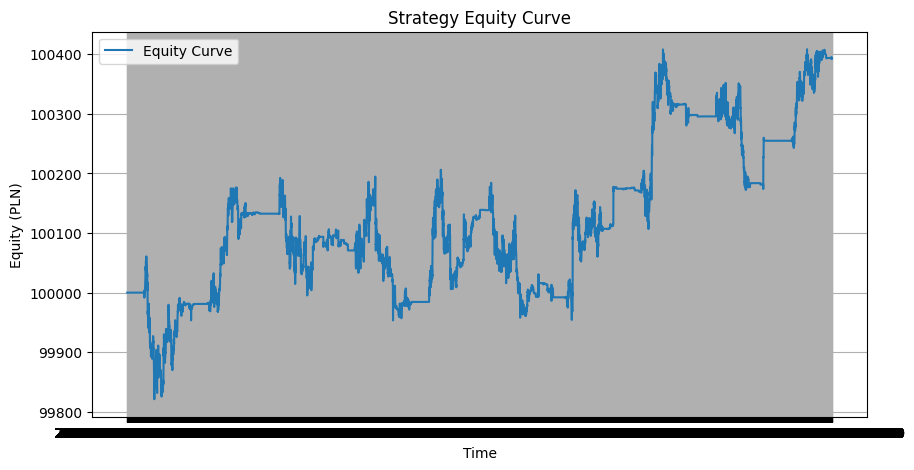

In [366]:
# Plot equity curve
# Made with AI help
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(equity_curve, label='Equity Curve')
plt.title("Strategy Equity Curve")
plt.xlabel("Time")
plt.ylabel("Equity (PLN)")
plt.grid(True)
plt.legend()
plt.show()

In [367]:
# --- Sharpe Ratio ---
# Convert log returns → normal returns for Sharpe
normal_returns = np.exp(r_strategy) - 1

# assume daily data; annualize factor = √252
sharpe_ratio = (normal_returns.mean() / normal_returns.std()) * np.sqrt(252)

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.1028
